In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

### GSPC Index

In [4]:
df = pd.read_csv('../data/^gspc_raw_data.csv')
df = df[['Close', 'High', 'Low', 'Open']]
df = df.drop(index=[0, 1]).reset_index(drop=True)

In [5]:
df

,Close,High,Low,Open
0,1399.4200439453125,1455.219970703125,1397.4300537109375,1455.219970703125
1,1402.1099853515625,1413.27001953125,1377.6800537109375,1399.4200439453125
2,1403.449951171875,1411.9000244140625,1392.0999755859375,1402.1099853515625
3,1441.469970703125,1441.469970703125,1400.72998046875,1403.449951171875
4,1457.5999755859375,1464.3599853515625,1441.469970703125,1441.469970703125
...,...,...,...,...
6377,5886.5498046875,5906.64013671875,5845.02001953125,5854.14990234375
6378,5892.580078125,5906.5498046875,5872.10986328125,5896.740234375
6379,5916.93017578125,5924.2099609375,5865.16015625,5869.81982421875
6380,5958.3798828125,5958.6201171875,5907.35986328125,5929.08984375


In [6]:
def create_sequence(data: pd.DataFrame, seq_length: int):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data.iloc[i:i + seq_length, :])
        y.append(data.iloc[i + seq_length, 3])
    return np.array(X), np.array(y)

In [7]:
seq_length = 20
num_features = 4
X,y = create_sequence(df, seq_length)
train_size = int(len(df)*0.8)
X_train, X_test = X[0:train_size, :], X[train_size:, :]
y_train, y_test = y[0:train_size], y[train_size:]
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(5105, 20, 4) (1257, 20, 4) (5105,) (1257,)


In [8]:
scalerX = MinMaxScaler(feature_range =(0,1))
scalery = MinMaxScaler(feature_range = (0,1))

x_train = scalerX.fit_transform(X_train.reshape(-1, num_features*seq_length))
x_test = scalerX.transform(X_test.reshape(-1, num_features*seq_length))
y_train = scalery.fit_transform(y_train.reshape(-1,1))
y_test = scalery.transform(y_test.reshape(-1,1))

In [9]:
x_train = torch.from_numpy(x_train.reshape(-1, seq_length, num_features)).float()
x_test = torch.from_numpy(x_test.reshape(-1, seq_length, num_features)).float()
y_train = torch.from_numpy(y_train).float()
y_test = torch.from_numpy(y_test).float()
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

torch.Size([5105, 20, 4]) torch.Size([1257, 20, 4]) torch.Size([5105, 1]) torch.Size([1257, 1])


#define model

In [10]:
class LSTMModel(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(LSTMModel, self).__init__()
    self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
    self.fc = nn.Linear(hidden_size, output_size)
  def forward(self, x):
    out, _ = self.lstm(x)
    out = self.fc(out[:, -1, :])
    return out

In [11]:
def train_model(model, criterion, optimizer, x_train, y_train, epochs=10, batch_size=30):
  model.train()
  for epoch in range(epochs):
    for i in range(0, len(x_train), batch_size):
      x_batch = x_train[i:i+batch_size]
      y_batch = y_train[i:i+batch_size]
      optimizer.zero_grad()
      loss = criterion(model(x_batch),y_batch)
      loss.backward()
      optimizer.step()
      print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

In [12]:
def evaluate_model(neurons, opt, x_train, y_train, x_test, y_test, epochs=10, batch_size=30):
  model = LSTMModel(input_size = num_features, hidden_size= neurons, output_size=1)
  criterion = nn.MSELoss()
  if opt == 'adam':
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
  else:
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

  train_model(model, criterion, optimizer, x_train, y_train, epochs=epochs, batch_size=batch_size)
  model.eval()
  with torch.no_grad():
    y_pred = model(x_test)
  mse = criterion(y_test, y_pred)
  return mse, model

In [13]:
best_mse = float('inf')
best_params = {}
neurons = [200,500,1000]
optimizers = ['adam', 'sgd']

for n in neurons:
  for opt in optimizers:
    mse, model = evaluate_model(n, opt, x_train, y_train, x_test, y_test)
    print(f'Neurons: {n}, Optimizer: {opt}, MSE: {mse}')
    if mse < best_mse:
      best_mse = mse
      best_params = {'neurons': n, 'optimizer': opt}
      best_model = model

Epoch [1/10], Loss: 0.0642
Epoch [1/10], Loss: 0.0548
Epoch [1/10], Loss: 0.0260
Epoch [1/10], Loss: 0.0483
Epoch [1/10], Loss: 0.0424
Epoch [1/10], Loss: 0.0218
Epoch [1/10], Loss: 0.0024
Epoch [1/10], Loss: 0.0146
Epoch [1/10], Loss: 0.0029
Epoch [1/10], Loss: 0.0022
Epoch [1/10], Loss: 0.0005
Epoch [1/10], Loss: 0.0017
Epoch [1/10], Loss: 0.0009
Epoch [1/10], Loss: 0.0009
Epoch [1/10], Loss: 0.0006
Epoch [1/10], Loss: 0.0000
Epoch [1/10], Loss: 0.0001
Epoch [1/10], Loss: 0.0002
Epoch [1/10], Loss: 0.0001
Epoch [1/10], Loss: 0.0004
Epoch [1/10], Loss: 0.0037
Epoch [1/10], Loss: 0.0007
Epoch [1/10], Loss: 0.0007
Epoch [1/10], Loss: 0.0002
Epoch [1/10], Loss: 0.0001
Epoch [1/10], Loss: 0.0007
Epoch [1/10], Loss: 0.0001
Epoch [1/10], Loss: 0.0009
Epoch [1/10], Loss: 0.0031
Epoch [1/10], Loss: 0.0027
Epoch [1/10], Loss: 0.0029
Epoch [1/10], Loss: 0.0019
Epoch [1/10], Loss: 0.0012
Epoch [1/10], Loss: 0.0004
Epoch [1/10], Loss: 0.0015
Epoch [1/10], Loss: 0.0021
Epoch [1/10], Loss: 0.0003
E

Best MSE: 0.025323331356048584
Best Params: {'neurons': 1000, 'optimizer': 'sgd'}
MSE: 0.025323331356048584


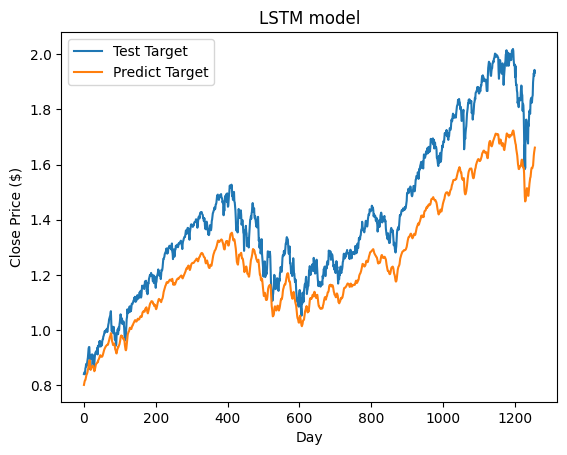

In [14]:

print(f'Best MSE: {best_mse}')
print(f'Best Params: {best_params}')

# Dự đoán và vẽ đồ thị
best_model.eval()
with torch.no_grad():
    y_pred = best_model(x_test)

mse = mean_squared_error(y_test.numpy(), y_pred.numpy())
print(f'MSE: {mse}')

plt.title("LSTM model")
plt.xlabel("Day")
plt.ylabel("Close Price ($)")
plt.plot(y_test.numpy(), label="Test Target")
plt.plot(y_pred.numpy(), label="Predict Target")
plt.legend()
plt.show()

In [15]:
# Save model
torch.save(best_model.state_dict(), 'GSPC_lstm_regression.pth')

### IBM Stock

In [16]:
df_ibm = pd.read_csv('../data/ibm_raw_data.csv')
df_ibm = df_ibm[['Close', 'High', 'Low', 'Open']]
df_ibm = df_ibm.drop(index=[0, 1]).reset_index(drop=True)

In [17]:
df_ibm

,Close,High,Low,Open
0,107.13432312011719,109.46463012695312,105.9990463256836,108.98661804199219
1,110.8986587524414,114.48374938964844,107.19407653808594,107.97084045410156
2,108.98661804199219,113.70697784423828,108.50860595703125,112.81070709228516
3,108.50860595703125,112.7509536743164,105.76004028320312,112.09368896484375
4,112.81070709228516,114.12523651123047,110.3011474609375,112.09368896484375
...,...,...,...,...
6378,257.82000732421875,260.54998779296875,256.2200012207031,257.6000061035156
6379,266.67999267578125,267.42999267578125,258.6099853515625,259.010009765625
6380,266.760009765625,267.9800109863281,264.5899963378906,266.3500061035156
6381,268.4100036621094,269.1400146484375,265.0799865722656,265.45001220703125


In [18]:
X,y = create_sequence(df_ibm, seq_length)
train_size = int(len(df)*0.8)
X_train, X_test = X[0:train_size, :], X[train_size:, :]
y_train, y_test = y[0:train_size], y[train_size:]
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(5105, 20, 4) (1258, 20, 4) (5105,) (1258,)


In [19]:
scalerX = MinMaxScaler(feature_range =(0,1))
scalery = MinMaxScaler(feature_range = (0,1))

x_train = scalerX.fit_transform(X_train.reshape(-1, num_features*seq_length))
x_test = scalerX.transform(X_test.reshape(-1, num_features*seq_length))
y_train = scalery.fit_transform(y_train.reshape(-1,1))
y_test = scalery.transform(y_test.reshape(-1,1))

In [20]:
x_train = torch.from_numpy(x_train.reshape(-1, seq_length, num_features)).float()
x_test = torch.from_numpy(x_test.reshape(-1, seq_length, num_features)).float()
y_train = torch.from_numpy(y_train).float()
y_test = torch.from_numpy(y_test).float()
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

torch.Size([5105, 20, 4]) torch.Size([1258, 20, 4]) torch.Size([5105, 1]) torch.Size([1258, 1])


In [21]:
best_mse = float('inf')
best_params = {}
neurons = [200,500,1000]
optimizers = ['adam', 'sgd']

for n in neurons:
  for opt in optimizers:
    mse, model = evaluate_model(n, opt, x_train, y_train, x_test, y_test)
    print(f'Neurons: {n}, Optimizer: {opt}, MSE: {mse}')
    if mse < best_mse:
      best_mse = mse
      best_params = {'neurons': n, 'optimizer': opt}
      best_model = model

Epoch [1/10], Loss: 0.1335
Epoch [1/10], Loss: 0.0771
Epoch [1/10], Loss: 0.0581
Epoch [1/10], Loss: 0.0902
Epoch [1/10], Loss: 0.1172
Epoch [1/10], Loss: 0.0850
Epoch [1/10], Loss: 0.0053
Epoch [1/10], Loss: 0.0140
Epoch [1/10], Loss: 0.0033
Epoch [1/10], Loss: 0.0060
Epoch [1/10], Loss: 0.0040
Epoch [1/10], Loss: 0.0076
Epoch [1/10], Loss: 0.0014
Epoch [1/10], Loss: 0.0008
Epoch [1/10], Loss: 0.0009
Epoch [1/10], Loss: 0.0023
Epoch [1/10], Loss: 0.0012
Epoch [1/10], Loss: 0.0061
Epoch [1/10], Loss: 0.0184
Epoch [1/10], Loss: 0.0124
Epoch [1/10], Loss: 0.0066
Epoch [1/10], Loss: 0.0007
Epoch [1/10], Loss: 0.0029
Epoch [1/10], Loss: 0.0195
Epoch [1/10], Loss: 0.0020
Epoch [1/10], Loss: 0.0434
Epoch [1/10], Loss: 0.0024
Epoch [1/10], Loss: 0.0145
Epoch [1/10], Loss: 0.0113
Epoch [1/10], Loss: 0.0068
Epoch [1/10], Loss: 0.0118
Epoch [1/10], Loss: 0.0067
Epoch [1/10], Loss: 0.0052
Epoch [1/10], Loss: 0.0055
Epoch [1/10], Loss: 0.0007
Epoch [1/10], Loss: 0.0007
Epoch [1/10], Loss: 0.0025
E

Best MSE: 0.005728965625166893
Best Params: {'neurons': 1000, 'optimizer': 'sgd'}
MSE: 0.00572896609082818


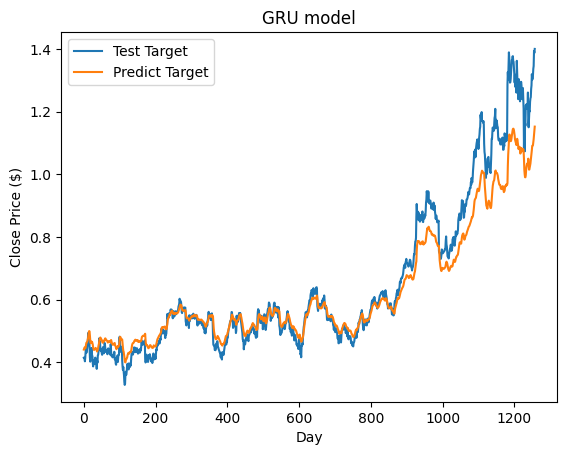

In [22]:

print(f'Best MSE: {best_mse}')
print(f'Best Params: {best_params}')

# Dự đoán và vẽ đồ thị
best_model.eval()
with torch.no_grad():
    y_pred = best_model(x_test)

mse = mean_squared_error(y_test.numpy(), y_pred.numpy())
print(f'MSE: {mse}')

plt.title("GRU model")
plt.xlabel("Day")
plt.ylabel("Close Price ($)")
plt.plot(y_test.numpy(), label="Test Target")
plt.plot(y_pred.numpy(), label="Predict Target")
plt.legend()
plt.show()

In [23]:
# Save model
torch.save(best_model.state_dict(), 'IBM_lstm_regression.pth')